In [38]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np


# Load the iris dataset
df = pd.read_csv('./iris.data', header=None)

# Establish a numberical mapping of the label classes
labels = {
    'Iris-setosa' : 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2,
}

# Split the dataframe in to feature and label datasets
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].map(labels).to_numpy()

In [39]:
# Define PCA decomposition
def pca(X, k=None):
    # Calculate the mean of the training features
    M = np.mean(X, axis=0)

    # Perform SVD on the centred training dataset
    U, S, V = np.linalg.svd(X - M, full_matrices=True)

    # ...
    W = V
    D = np.zeros(X.shape)
    np.fill_diagonal(D, S)
    Z = U @ D

    # Return the mean of the training features, the principle components and the projected training dataset
    if k:
        return M, W[:k], Z[:,:k]
    else:
        return M, W, Z


# Identify the top 2 principle components in the dataset 
_, _, Z = pca(X, k=2)

[]

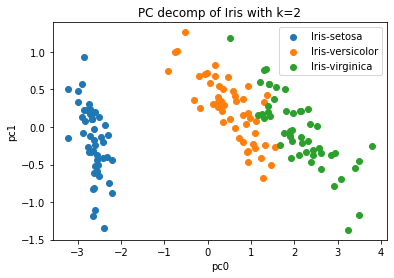

In [40]:

# Plot the decomposition of the data with the top 2 PCs
for label_name, label_id in labels.items():
    C = Z[np.where(y == label_id)]
    plt.scatter(C[:,0], C[:,1], label=label_name)

plt.title('PC decomp of Iris with k=2')
plt.xlabel('pc0')
plt.ylabel('pc1')
plt.legend(loc='upper right')
plt.plot()

In [41]:

# Multi-class linear regression classifier model
class Perceptron:

    def __init__(self, X, y, itrs=50):
        # Prepend a bias column to the dataset
        X = np.hstack((np.ones((len(X),1)), X))

        # Train the regression weights
        self.W = self.train(X, y, itrs)


    def train(self, X, y, itrs=50):
        # Determine the shape of the weight matrix 
        classes = len(np.unique(y))
        dimensions = X.shape[1]

        # Initialise the weights
        W = np.zeros((classes, dimensions))

        # Iteratively fit the weights
        for i in range(0, itrs):
            # Shuffle the training data
            X, y = shuffle(X, y)

            # Iterate through all feature-class pairs
            for x_i, y_i in zip(X, y):

                # Predict the class
                y_p = np.argmax(np.dot(W, x_i), axis=0)

                # Adjust the weights if the prediction is wrong
                if y_p != y_i:
                    W[y_i] += x_i
                    W[y_p] -= x_i
        
        # Return the weights
        return W
    

    def predict(self, X):
        # Prepend a bias column to the dataset
        X = np.hstack((np.ones((len(X),1)), X))

        # Return the class index with the max predicted value
        return np.argmax(X @ self.W.T, axis=1)


    def errors(self, X, y):
        # Predict the dataset classes
        y_ = self.predict(X)

        # Compare the prediction and ground classes
        return np.sum(y != y_)


    def accuracy(self, X, y):
        # Predict the dataset classes
        y_ = self.predict(X)

        # Compare the prediction and ground classes
        return np.sum(y == y_) / len(y)
          


# Execute on the 2D projection
m1 = Perceptron(Z, y)
print('2D: ', m1.accuracy(Z, y))

# Execute on the raw
m2 = Perceptron(X, y)
print('Raw: ', m2.accuracy(X, y))

# Execute on the 4D projection
_, _, Z = pca(X)
m3 = Perceptron(Z, y)
print('4D: ', m3.accuracy(Z, y))

2D:  0.9733333333333334
Raw:  0.9466666666666667
4D:  0.9533333333333334


In [42]:
#
def rbgKernel(X, gam):
    # Quadtratic kernel
    # K = (X @ X.T) ** 2

    # Gaussian kernel
    K = np.exp(gam * np.linalg.norm(X[:,:,None]-X.T[None,:,:], ord=2, axis=1)) 

    # Form matrix A
    A = np.zeros(K.shape)
    np.fill_diagonal(A, 1 / len(X))

    # Normalise and return the kernel
    return K - A @ K - K @ A + (A @ K) @ A


# Determine gamma range
X_centred = X - np.mean(X, axis=0)
var = X_centred.var(axis=0)
eps = 0.05
gam_min = 0.5 / (var.max() + eps)
gam_max = 0.5 / (var.min() + eps)
gam_range = np.arange(gam_min, gam_max, 0.10)
k_range = np.arange(X.shape[1]+1, X.shape[0]+1, 1)


# Create a table to store the error of each model
model_errors = np.empty((len(k_range), len(gam_range)))


# Iterate over gamma values 
for i, gam in enumerate(gam_range):
    # Compute the kernel
    K = rbgKernel(X, gam)
    _, W, Z = pca(K)

    # Try the top k components between d and n
    for j, k in enumerate(k_range):
        # Select the top k components from the decomposition
        W_ = W[:k]
        Z_ = Z[:,:k]

        # Train a model with the parameters
        m = Perceptron(Z_, y)

        # Record the models number of training errors
        model_errors[j, i] = m.errors(Z_, y)


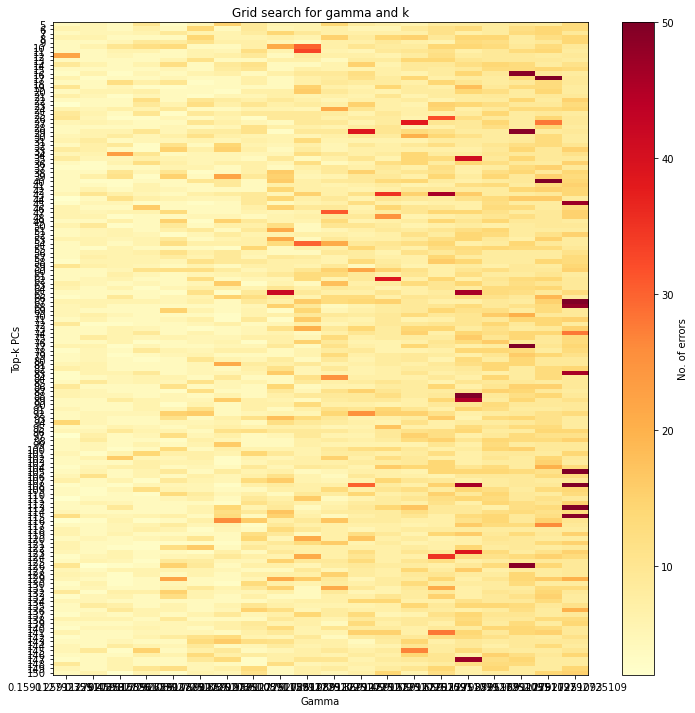

In [44]:
# Plot the grid search
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(model_errors, aspect='auto', interpolation='nearest', cmap='YlOrRd')
cb = fig.colorbar(im, ax=ax)
cb.set_label('No. of errors')
plt.xticks(np.arange(len(gam_range)), gam_range)
plt.yticks(np.arange(len(k_range)), k_range)
plt.title('Grid search for gamma and k')
plt.xlabel('Gamma')
plt.ylabel('Top-k PCs')
plt.show()
